In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.6 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LongformerModel, LongformerTokenizer
from transformers import RobertaTokenizer, RobertaModel
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from transformers import EarlyStoppingCallback
from torch.optim import AdamW

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/commentbig5sample.csv", encoding='latin-1')

In [ ]:
df.head()

Unnamed: 0.1  Unnamed: 0           author  \
0             0           0  MetricExpansion   
1             1        2768         cyanisis   
2             2       18416      BadgerKid96   
3             3       20735    Silverlight42   
4             4       63770     pseudomuffin   

                                                body  agreeableness  openness  \
0  Those stats come test. [Echoing comment I made...           0.30      0.70   
1  Ok ok op. Some advice "just don't" Set direct ...           0.09      0.59   
2  It seem like went pretty fast I look back it. ...           0.77      0.73   
3              ok who's using force powers again...?           0.09      0.61   
4  Will recommend--works well name brand, I use t...           0.79      0.84   

   conscientiousness  extraversion  neuroticism  count  word_count  
0               0.15          0.15         0.50   2768          77  
1               0.05          0.72         0.07  15648          47  
2               0.73          0.01         0.98   2319          36  
3               0.13          0.04         0.72  43035           6  
4               0.86          0.53         0.01   3337          10

In [ ]:
df.shape

(1568, 11)

In [ ]:

# Drop columns
df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)


In [ ]:
df.head()

In [ ]:
df.shape

(1568, 9)

RoBERTa

In [ ]:

# # Initialize tokenizer

# tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Preprocess tweets: tokenize and pad/truncate
max_length = 64  # Choose the max_length that best suits your data

df['body'] = df['body'].apply(lambda x: tokenizer.encode_plus(x, truncation=True, padding='max_length', max_length=max_length))



# Split into train and test first
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

# Split df_train into train and validation
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)


In [ ]:
# Define a PyTorch dataset
class PersonalityDataset(Dataset):
    def __init__(self, tweets, targets):
        self.tweets = tweets
        self.targets = targets

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.tweets[idx]['input_ids'], dtype=torch.long)
        attention_mask = torch.tensor(self.tweets[idx]['attention_mask'], dtype=torch.long)
        targets = torch.tensor(self.targets[idx], dtype=torch.float)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'targets': targets
        }



In [ ]:
# Define the model

class RoBERTaForPersonalityTraits(torch.nn.Module):
    def __init__(self):
        super(RoBERTaForPersonalityTraits, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 5)  # Update the output size to 5

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        output = self.dropout(pooled_output)
        output = self.linear(output)
        return output

In [ ]:
# Prepare data loaders
batch_size = 16
train_dataset = PersonalityDataset(df_train['body'].tolist(), df_train[['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']].values)
val_dataset = PersonalityDataset(df_val['body'].tolist(), df_val[['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']].values)
test_dataset = PersonalityDataset(df_test['body'].tolist(), df_test[['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model and define optimizer and loss function

model = RoBERTaForPersonalityTraits()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.MSELoss()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Training loop
epochs = 15

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0
accumulation_steps = 16

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad() if i % accumulation_steps == 0 else None

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)

        # Backward pass
        loss = loss / accumulation_steps
        loss.backward()
        if (i+1) % accumulation_steps == 0 or i+1 == len(train_loader):  # update on last step even if accumulation steps have not been reached
            optimizer.step()
            optimizer.zero_grad()  # make sure to reset gradient after updating

        total_loss += loss.item()

        # Delete unnecessary tensors to save GPU memory
        del input_ids
        del attention_mask
        del targets
        del outputs
        torch.cuda.empty_cache()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Train loss at epoch {epoch + 1}: {avg_train_loss}")

    # Validation loop
    model.eval()
    val_total_loss = 0
    all_predictions = [[] for _ in range(5)]  # Separate predictions for each trait
    all_targets = [[] for _ in range(5)]  # Separate targets for each trait

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, targets)

            val_total_loss += loss.item()

            # Split predictions and targets for each trait
            for i in range(5):
                all_predictions[i].extend(outputs[:, i].cpu().numpy())
                all_targets[i].extend(targets[:, i].cpu().numpy())

    avg_val_loss = val_total_loss / len(val_loader)
    print(f"Validation loss at epoch {epoch + 1}: {avg_val_loss}")

    # Check if early stopping conditions are met
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # reset counter
        # save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1  # increment counter
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break  # break out of the training loop


# After the validation loop...
trait_names = ["Extroversion", "Neuroticism", "Agreeableness", "Conscientiousness", "Openness"]

for i in range(5):
    predictions = all_predictions[i]
    targets = all_targets[i]

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)

    print(f"For {trait_names[i]}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}\n")

Train loss at epoch 1: 0.0066578404300592165
Validation loss at epoch 1: 0.09870630981666702
Train loss at epoch 2: 0.006717008182948286
Validation loss at epoch 2: 0.0984403028019837
Train loss at epoch 3: 0.0065782450054856865
Validation loss at epoch 3: 0.0978401851441179
Train loss at epoch 4: 0.00651490351354534
Validation loss at epoch 4: 0.09853653875844819
Train loss at epoch 5: 0.006299186624925245
Validation loss at epoch 5: 0.09836096103702273
Train loss at epoch 6: 0.006357621393081817
Validation loss at epoch 6: 0.09835819208196231
Early stopping triggered.
For Extroversion:
MSE: 0.10543157905340195
RMSE: 0.32470229268074036
R^2: -0.004773237723810775

For Neuroticism:
MSE: 0.08354497700929642
RMSE: 0.2890414893627167
R^2: -0.0064318593110637146

For Agreeableness:
MSE: 0.09365144371986389
RMSE: 0.3060252368450165
R^2: -0.04007296666228055

For Conscientiousness:
MSE: 0.09984192997217178
RMSE: 0.31597772240638733
R^2: -0.03894556959476314

For Openness:
MSE: 0.107657544314

In [ ]:
# Evaluation on test set
model.eval()
test_total_loss = 0
all_predictions = [[] for _ in range(5)]  # Separate predictions for each trait
all_targets = [[] for _ in range(5)]  # Separate targets for each trait

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, targets)

        test_total_loss += loss.item()

        # Split predictions and targets for each trait
        for i in range(5):
            all_predictions[i].extend(outputs[:, i].cpu().numpy())
            all_targets[i].extend(targets[:, i].cpu().numpy())

trait_names = ["Ext", "Neu", "Agre", "Con", "Ope"]

for i in range(5):
    predictions = all_predictions[i]
    targets = all_targets[i]

    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    print(f"For {trait_names[i]}:")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R^2: {r2}\n")

For Ext:
MSE: 0.09587880969047546
RMSE: 0.309643030166626
MAE: 0.27104127407073975
R^2: -0.006951997771070584

For Neu:
MSE: 0.08020368963479996
RMSE: 0.28320255875587463
MAE: 0.23642729222774506
R^2: -0.023330192603310707

For Agre:
MSE: 0.10072185099124908
RMSE: 0.3173670470714569
MAE: 0.2799871265888214
R^2: -0.022853870381517538

For Con:
MSE: 0.0923282578587532
RMSE: 0.30385565757751465
MAE: 0.261822909116745
R^2: -0.007598169543959532

For Ope:
MSE: 0.09971510618925095
RMSE: 0.3157769739627838
MAE: 0.277862012386322
R^2: 0.007330497978190742



In [ ]:



df_predictions = pd.DataFrame(np.transpose(all_predictions), columns=trait_names)


correlation_matrix_predictions = df_predictions.corr()
print("\nCorrelation matrix for predicted values:")
print(correlation_matrix_predictions)



Correlation matrix for predicted values:
           Ext       Neu      Agre       Con       Ope
Ext   1.000000  0.204444  0.437371 -0.099411  0.035910
Neu   0.204444  1.000000  0.116790  0.430080 -0.111548
Agre  0.437371  0.116790  1.000000  0.074576  0.010608
Con  -0.099411  0.430080  0.074576  1.000000 -0.155790
Ope   0.035910 -0.111548  0.010608 -0.155790  1.000000


In [ ]:
def color_cells(val):
    if val < 0:
        return 'background-color: red'
    elif val == 1:
        return 'background-color: yellow'
    else:
        return 'background-color: green'

styled_df = correlation_matrix_predictions.style.applymap(color_cells)

styled_df

<Axes: >

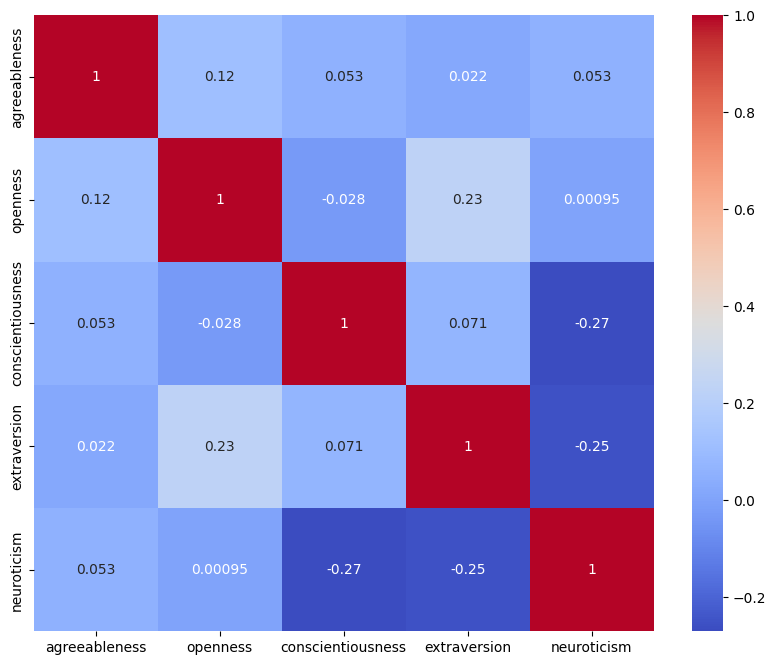

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

**Second-512,16,16**

For Extroversion:
MSE: 0.02121167816221714
RMSE: 0.14564229547977448
R^2: -0.019009624479152665

For Neuroticism:
MSE: 0.04042501747608185
RMSE: 0.2010597288608551
R^2: 0.05767663214598129

For Agreeableness:
MSE: 0.021378954872488976
RMSE: 0.14621543884277344
R^2: 0.012487692648050386

For Conscientiousness:
MSE: 0.016164032742381096
RMSE: 0.12713785469532013
R^2: -0.14099055785629733

For Openness:
MSE: 0.021685434505343437
RMSE: 0.14725975692272186
R^2: -0.1355281245878932

For Extroversion:
MSE: 0.02021007053554058
RMSE: 0.14216212928295135
R^2: 0.029107548661968186

For Neuroticism:
MSE: 0.043879713863134384
RMSE: 0.2094748467206955
R^2: -0.02285370872065351

For Agreeableness:
MSE: 0.02161208726465702
RMSE: 0.14701050519943237
R^2: 0.0017191188102697597

For Conscientiousness:
MSE: 0.015742043033242226
RMSE: 0.12546730041503906
R^2: -0.11120312050874404

For Openness:
MSE: 0.019112927839159966
RMSE: 0.13824951648712158
R^2: -0.000822355546864495